### 1. 
Import data, split, normalize and save. (Only run once!)

In [1]:
import os
import numpy as np
import pandas as pd
import torch

def fit_minmax(X):
    """Fit per-feature min-max on X (2D). Returns (mins, ranges) with safe ranges."""
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = maxs - mins
    rng_safe = np.where(rng > 0, rng, 1.0)  # avoid division by zero (constant features)
    return mins.astype(DTYPE), rng_safe.astype(DTYPE)

def transform_minmax(X, mins, rng_safe):
    return ((X - mins) / rng_safe).astype(DTYPE)

def inverse_minmax(X_scaled, mins, rng_safe):
    return (X_scaled * rng_safe + mins).astype(DTYPE)

def split_dataframe_rows(df, train_frac, val_frac, test_frac, seed=42):
    """Split the *rows* of the original df into train/val/test by fraction."""
    assert abs((train_frac + val_frac + test_frac) - 1.0) < 1e-8, "Fractions must sum to 1."
    rng = np.random.default_rng(seed)
    idx = df.index.to_numpy()
    rng.shuffle(idx)

    n = len(idx)
    n_train = int(round(train_frac * n))
    n_val = int(round(val_frac * n))
    n_test = n - n_train - n_val

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]

    return df.loc[train_idx], df.loc[val_idx], df.loc[test_idx]


def create_inp_out(df_split):
    """
    Creates inputs X and outputs Y of given df already splitted
    """
    inputs, outputs = [], []

    for _, row in df_split.iterrows():
        # ---- scalar inputs (with the same preprocessing as in your pipeline) ----
        dV_ges   = float(row["dV_ges"]) / 3.6 * 1e-6
        eps_0    = float(row["eps_0"])
        phi_0    = float(row["phi_0"])
        h_dis_0  = float(row["h_dis_0"])
        h_c_0    = float(row["h_c_0"])
        rho_c    = float(row["rho_c"])
        rho_d    = float(row["rho_d"])
        eta_c    = float(row["eta_c"])
        eta_d    = float(row["etc_d"])
        sigma    = float(row["sigma"])
        T        = float(row["T"])
        r_s_star = float(row["r_S_star"])
        h_p_star = float(row["h_p_star"])
        D_A      = float(row["D_A"])
        L_A      = float(row["L_A"])
        lam      = float(row["lambda"])

        # ---- expand: one sample per DPZ position ----
        inputs.append([dV_ges, eps_0, phi_0, h_dis_0, h_c_0, rho_c, rho_d,
                       eta_c, eta_d, sigma, T, r_s_star, h_p_star, D_A, L_A])
        outputs.append(lam)

    X = np.array(inputs, dtype=DTYPE)
    Y = np.array(outputs, dtype=DTYPE)
    return X, Y

In [2]:
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15
SEED = 42
DTYPE = np.float32
CSV_PATH = os.path.join("Input", "df_lam.csv")

# 1) Read original CSV
df = pd.read_csv(CSV_PATH)

# 2) Split by original rows
train_df, val_df, test_df = split_dataframe_rows(df, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=SEED)
print(f"Row splits: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
test_df.to_csv("df_lam_te.csv", index=False)

# 3) Expand each split separately (no cross-split leakage)
X_train, Y_train = create_inp_out(train_df)
X_val,   Y_val   = create_inp_out(val_df)
X_test,  Y_test  = create_inp_out(test_df)

print("Sample counts:", f"train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
print("Feature/Target dims. for training:", X_train.shape[1], Y_train.shape[1])

# 4) Fit Min–Max on TRAIN only; transform all splits
x_mins, x_rng = fit_minmax(X_train)
y_mins, y_rng = fit_minmax(Y_train)

X_train_n = transform_minmax(X_train, x_mins, x_rng)
X_val_n   = transform_minmax(X_val,   x_mins, x_rng)
X_test_n  = transform_minmax(X_test,  x_mins, x_rng)

Y_train_n = transform_minmax(Y_train, y_mins, y_rng)
Y_val_n   = transform_minmax(Y_val,   y_mins, y_rng)
Y_test_n  = transform_minmax(Y_test,  y_mins, y_rng)

# 5) Convert to torch tensors (ready for DataLoaders)
X_train_t = torch.from_numpy(X_train_n)
Y_train_t = torch.from_numpy(Y_train_n)
X_val_t   = torch.from_numpy(X_val_n)
Y_val_t   = torch.from_numpy(Y_val_n)
X_test_t  = torch.from_numpy(X_test_n)
Y_test_t  = torch.from_numpy(Y_test_n)

print("Torch tensors:",
      X_train_t.shape, Y_train_t.shape,
      X_val_t.shape,   Y_val_t.shape,
      X_test_t.shape,  Y_test_t.shape)

# Save normalization params for inference-time inverse-transform
np.savez(
    "minmax_params_dnn_7_(lam).npz",
    x_mins=x_mins, x_rng=x_rng,
    y_mins=y_mins, y_rng=y_rng
)

# Save splits as torch tensors
data = {
    "X_train_t": X_train_t,
    "Y_train_t": Y_train_t,
    "X_val_t":   X_val_t,
    "Y_val_t":   Y_val_t,
    "X_test_t":  X_test_t,
    "Y_test_t":  Y_test_t,
    "X_train_n": X_train_n,
    "Y_train_n": Y_train_n,
    "X_val_n":   X_val_n,
    "Y_val_n":   Y_val_n,
    "X_test_n":  X_test_n,
    "Y_test_n":  Y_test_n,
}

# Save all in one file
torch.save(data, 'datasets_dnn_7_(lam).pt')

Row splits: train=276, val=59, test=60
Sample counts: train=276, val=59, test=60


IndexError: tuple index out of range

### 2. 
Create model

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
# ----------------------------
# Load datasets
# ----------------------------
loaded_data = np.load("saved_models/dnn_4_(ye)/datasets_dnn_4_(ye).npz")

Xn_train = loaded_data["Xn_train"]
Yn_train = loaded_data["Yn_train"]
Mn_train = loaded_data["Mn_train"]
Xn_val   = loaded_data["Xn_val"]
Yn_val   = loaded_data["Yn_val"]
Mn_val   = loaded_data["Mn_val"]
Xn_test  = loaded_data["Xn_test"]
Yn_test  = loaded_data["Yn_test"]
Mn_test  = loaded_data["Mn_test"]

print("Train shapes:", Xn_train.shape, Yn_train.shape, Mn_train.shape)
print("Val shapes:",   Xn_val.shape,   Yn_val.shape,   Mn_val.shape)
print("Test shapes:",  Xn_test.shape,  Yn_test.shape,  Mn_test.shape)

# ----------------------------
# Load scaling params
# ----------------------------
loaded_data_n = np.load("saved_models/dnn_4_(ye)/minmax_params_dnn_4_(ye).npz")
x_mins = loaded_data_n["x_mins"]
x_rng  = loaded_data_n["x_rng"]
y_mins = loaded_data_n["y_mins"]
y_rng  = loaded_data_n["y_rng"]

print("x_mins shape:", x_mins.shape)
print("y_mins shape:", y_mins.shape)

Train shapes: (67, 3) (67, 2) (67, 2)
Val shapes: (14, 3) (14, 2) (14, 2)
Test shapes: (14, 3) (14, 2) (14, 2)
x_mins shape: (3,)
y_mins shape: (2,)


In [2]:
EPS = 1e-12  # numerical safety
import torch.nn as nn
HIDDEN = [128, 128, 128]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MultiHead(nn.Module):
    def __init__(self, in_dim=3, hidden=HIDDEN):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        self.trunk = nn.Sequential(*layers)
        self.head_lambda = nn.Linear(d, 1)   # -> λ
        self.head_geom   = nn.Linear(d, 1)   # -> [H, L]

    def forward(self, x):
        z = self.trunk(x)
        lam = self.head_lambda(z)  # (B,1)
        L  = self.head_geom(z)    # (B,1)
        return lam, L
    

class XYMDataset(Dataset):
    def __init__(self, X, Y, M):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i], self.Y[i], self.M[i]

def masked_mse(pred, target, mask, eps=EPS):
    """
    pred, target, mask: (B,D)
    Computes mean square error only over entries with mask=1.
    """
    se = (pred - target)**2 * mask
    denom = mask.sum().clamp_min(eps)
    return se.sum() / denom

def evaluate(dloader, model, tgt_min, tgt_rng, device=DEVICE):
    """Return MAE/MSE on the original (denormalized) scale for each target [λ,L]."""
    model.eval()
    mae = np.zeros(2, dtype=np.float64)
    mse = np.zeros(2, dtype=np.float64)
    count = np.zeros(2, dtype=np.float64)

    with torch.no_grad():
        for xb, yb, mb in dloader:
            xb = xb.to(device)
            yb = yb.to(device)        # normalized targets
            mb = mb.to(device)

            lam_pred, L_pred = model(xb)
            pred = torch.cat([lam_pred, L_pred], dim=1)  # (B,3)

            pred_np = pred.cpu().numpy()
            y_np    = yb.cpu().numpy()
            m_np    = mb.cpu().numpy().astype(bool)

            # inverse min-max per dim
            for j in range(2):
                p = pred_np[:, j] * tgt_rng[j] + tgt_min[j]
                t = y_np[:, j]    * tgt_rng[j] + tgt_min[j]
                m = m_np[:, j]
                if m.any():
                    diff = p[m] - t[m]
                    mae[j] += np.abs(diff).sum()
                    mse[j] += (diff**2).sum()
                    count[j] += m.sum()

    mae = np.where(count>0, mae/count, np.nan)
    mse = np.where(count>0, mse/count, np.nan)
    return mae, mse


model = MultiHead(in_dim=3, hidden=HIDDEN).to(DEVICE)

### 3. 
Train the model

In [3]:
EPOCHS = 500
BATCH_SIZE = len(Xn_train)
LR = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.1, patience=30)


ds_tr = XYMDataset(Xn_train, Yn_train, Mn_train)
ds_va = XYMDataset(Xn_val, Yn_val, Mn_val)
ds_te = XYMDataset(Xn_test, Yn_test, Mn_test)
dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

valid_counts = Mn_train.sum(axis=0)  # (2,)
w_lam = 1.0 / max(valid_counts[0], 1.0)
w_geo = 1.0 / max(valid_counts[1], 1.0)

losses_history = []


for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb, mb in dl_tr:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)  # normalized targets
        mb = mb.to(DEVICE)

        lam_pred, L_pred = model(xb)          # (B,1), (B,1)
        lam_t = yb[:, [0]]                      # (B,1)
        L_t  = yb[:, [1]]                      # (B,1)
        m_lam = mb[:, [0]]
        m_geo = mb[:, [1]]

        loss_lam = masked_mse(lam_pred, lam_t, m_lam)
        loss_geo = masked_mse(L_pred,  L_t,  m_geo)

        loss = w_lam * loss_lam + w_geo * loss_geo

        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)

    if epoch % 10 == 0 or epoch == 1:
        _, mse_va = evaluate(dl_va, model, y_mins, y_rng)
        scheduler.step(np.mean(mse_va))
        losses_history.append([loss.item(), mse_va[0], mse_va[1]])
        print(f"Epoch {epoch:4d} | train_loss ~ {total_loss/len(ds_tr):.4e} | VA-MSE [λ,L]= {mse_va}")

Epoch    1 | train_loss ~ 4.1373e-02 | VA-MSE [λ,L]= [0.08998746 0.09116926]
Epoch   10 | train_loss ~ 4.8548e-03 | VA-MSE [λ,L]= [0.00472731 0.01870024]
Epoch   20 | train_loss ~ 4.3191e-03 | VA-MSE [λ,L]= [0.00500374 0.01659206]
Epoch   30 | train_loss ~ 4.1343e-03 | VA-MSE [λ,L]= [0.00325355 0.01540937]
Epoch   40 | train_loss ~ 3.4840e-03 | VA-MSE [λ,L]= [0.00115568 0.01094982]
Epoch   50 | train_loss ~ 2.9145e-03 | VA-MSE [λ,L]= [0.00151675 0.00747611]
Epoch   60 | train_loss ~ 2.4226e-03 | VA-MSE [λ,L]= [0.00080499 0.00385196]
Epoch   70 | train_loss ~ 2.0902e-03 | VA-MSE [λ,L]= [0.00102408 0.00160871]
Epoch   80 | train_loss ~ 1.9891e-03 | VA-MSE [λ,L]= [0.0011539  0.00175628]
Epoch   90 | train_loss ~ 1.9179e-03 | VA-MSE [λ,L]= [0.00105761 0.00145025]
Epoch  100 | train_loss ~ 1.8366e-03 | VA-MSE [λ,L]= [0.00097296 0.0010848 ]
Epoch  110 | train_loss ~ 1.7552e-03 | VA-MSE [λ,L]= [0.00083958 0.00086617]
Epoch  120 | train_loss ~ 1.6661e-03 | VA-MSE [λ,L]= [0.00075435 0.00072862]

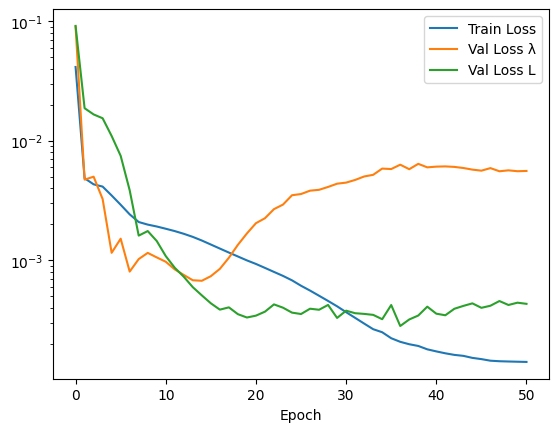

In [4]:
import matplotlib.pyplot as plt
losses_history = np.array(losses_history)
plt.plot(losses_history[:,0], label='Train Loss')
plt.plot(losses_history[:,1], label='Val Loss λ')
plt.plot(losses_history[:,2], label='Val Loss L')
# plt.vlines(np.argmin(losses_history[:,1]), linestyles='--', ymin=0, ymax=max(losses_history[:,1]), label='min_L_val', color='gray')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 4.
Evaluate results

In [5]:
# -------------------
# Final evaluation on TEST
# -------------------
mae_te, mse_te = evaluate(dl_te, model, tgt_min, tgt_rng)
mape_te = mae_te / tgt_rng * 100.0  # in percent
print("TEST  MAPE [λ,H,L]:", mape_te, '%')
print("TEST  MAE [λ,H,L]:", mae_te)
print("TEST  MSE [λ,H,L]:", mse_te)

NameError: name 'tgt_min' is not defined

### 5.
Optuna analysis

In [6]:
# optuna_dnn_study.py
import os, json, math, time, random
import numpy as np
import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# Repro & device
# ----------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load datasets
# ----------------------------
ROOT = "saved_models/dnn_4_(ye)"
data_npz = os.path.join(ROOT, "datasets_dnn_4_(ye).npz")
scal_npz = os.path.join(ROOT, "minmax_params_dnn_4_(ye).npz")

loaded = np.load(data_npz)
Xn_train = loaded["Xn_train"]; Yn_train = loaded["Yn_train"]; Mn_train = loaded["Mn_train"]
Xn_val   = loaded["Xn_val"];   Yn_val   = loaded["Yn_val"];   Mn_val   = loaded["Mn_val"]
Xn_test  = loaded["Xn_test"];  Yn_test  = loaded["Yn_test"];  Mn_test  = loaded["Mn_test"]

loaded_n = np.load(scal_npz)
x_mins = loaded_n["x_mins"]; x_rng = loaded_n["x_rng"]
y_mins = loaded_n["y_mins"]; y_rng = loaded_n["y_rng"]

print("Train shapes:", Xn_train.shape, Yn_train.shape, Mn_train.shape)
print("Val shapes:",   Xn_val.shape,   Yn_val.shape,   Mn_val.shape)
print("Test shapes:",  Xn_test.shape,  Yn_test.shape,  Mn_test.shape)
print("x_mins shape:", x_mins.shape)
print("y_mins shape:", y_mins.shape)

EPS = 1e-12

# ----------------------------
# Dataset & helpers
# ----------------------------
class XYMDataset(Dataset):
    def __init__(self, X, Y, M):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i], self.Y[i], self.M[i]

def masked_mse(pred, target, mask, eps=EPS):
    # pred, target, mask: (B, D) with D=2 here
    se = (pred - target)**2 * mask
    denom = mask.sum().clamp_min(eps)
    return se.sum() / denom

@torch.no_grad()
def evaluate_denorm(dloader, model, tgt_min, tgt_rng, device=DEVICE):
    """MAE/MSE on original (denormalized) scale for each of the two targets."""
    model.eval()
    mae = np.zeros(2, dtype=np.float64)
    mse = np.zeros(2, dtype=np.float64)
    count = np.zeros(2, dtype=np.float64)

    for xb, yb, mb in dloader:
        xb = xb.to(device)
        yb = yb.to(device)        # normalized targets
        mb = mb.to(device)

        lam_pred, L_pred = model(xb)
        pred = torch.cat([lam_pred, L_pred], dim=1)  # (B, 2)

        pred_np = pred.cpu().numpy()
        y_np    = yb.cpu().numpy()
        m_np    = mb.cpu().numpy().astype(bool)

        for j in range(2):
            p = pred_np[:, j] * tgt_rng[j] + tgt_min[j]
            t = y_np[:, j]    * tgt_rng[j] + tgt_min[j]
            m = m_np[:, j]
            if m.any():
                diff = p[m] - t[m]
                mae[j] += np.abs(diff).sum()
                mse[j] += (diff**2).sum()
                count[j] += m.sum()

    mae = np.where(count>0, mae/count, np.nan)
    mse = np.where(count>0, mse/count, np.nan)
    return mae, mse

# ----------------------------
# Flexible model to search
# ----------------------------
class FlexibleMultiHead(nn.Module):
    def __init__(self, in_dim=3, hidden_layers=(128,128,128),
                 activation="relu", dropout=0.0, use_bn=False):
        super().__init__()
        acts = {
            "relu": nn.ReLU,
            "leaky_relu": lambda: nn.LeakyReLU(negative_slope=0.01),
            "elu": nn.ELU,
            "gelu": nn.GELU,
        }
        Act = acts[activation]
        layers = []
        d = in_dim
        for h in hidden_layers:
            layers.append(nn.Linear(d, h))
            if use_bn:
                layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dropout and dropout > 0:
                layers.append(nn.Dropout(p=dropout))
            d = h
        self.trunk = nn.Sequential(*layers) if layers else nn.Identity()
        self.head_lambda = nn.Linear(d, 1)  # -> λ
        self.head_geom   = nn.Linear(d, 1)  # -> L

    def forward(self, x):
        z = self.trunk(x)
        lam = self.head_lambda(z)
        L   = self.head_geom(z)
        return lam, L

# ----------------------------
# Dataloaders (kept outside for speed)
# ----------------------------
def make_loaders(batch_size: int):
    train_ds = XYMDataset(Xn_train, Yn_train, Mn_train)
    val_ds   = XYMDataset(Xn_val,   Yn_val,   Mn_val)
    test_ds  = XYMDataset(Xn_test,  Yn_test,  Mn_test)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader

# ----------------------------
# Objective
# ----------------------------
def objective(trial: optuna.trial.Trial):
    # Search space
    n_layers = trial.suggest_int("n_layers", 1, 5)
    hidden_base = trial.suggest_categorical("hidden_base", [64, 128, 256, 384, 512])
    width_decay = trial.suggest_float("width_decay", 0.75, 1.35)  # geometric taper/expand
    hidden_layers = [int(max(32, round(hidden_base * (width_decay ** i)))) for i in range(n_layers)]

    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "elu", "gelu"])
    use_bn = trial.suggest_categorical("use_bn", [False, True])
    dropout = trial.suggest_float("dropout", 0.0, 0.4)

    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-9, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 96, 128, 192, 256])

    max_epochs = 80
    patience = 12  # early stopping on denorm val MSE
    train_loader, val_loader, _ = make_loaders(batch_size)

    model = FlexibleMultiHead(
        in_dim=Xn_train.shape[1],
        hidden_layers=tuple(hidden_layers),
        activation=activation,
        dropout=dropout,
        use_bn=use_bn
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # OneCycleLR often works well for MLPs
    steps_per_epoch = max(1, math.ceil(len(train_loader)))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=max_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=trial.suggest_float("onecycle_pct_start", 0.05, 0.4),
        div_factor=trial.suggest_float("onecycle_div_factor", 5.0, 50.0),
        final_div_factor=trial.suggest_float("onecycle_final_div_factor", 5.0, 50.0),
        three_phase=False,
        anneal_strategy="cos"
    )

    best_val = float("inf")
    best_state = None
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        model.train()
        running = 0.0; denom = 0.0

        for xb, yb, mb in train_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE); mb = mb.to(DEVICE)
            lam_pred, L_pred = model(xb)
            pred = torch.cat([lam_pred, L_pred], dim=1)  # (B, 2)

            loss = masked_mse(pred, yb, mb)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            scheduler.step()

            bsz = xb.size(0)
            running += loss.item() * bsz
            denom += bsz

        # Validation (denormalized)
        val_mae, val_mse = evaluate_denorm(val_loader, model, y_mins, y_rng, device=DEVICE)
        metric = float(np.nanmean(val_mse))  # mean over the two targets

        trial.report(metric, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if metric + 1e-12 < best_val:
            best_val = metric
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break  # early stop

    # Save the last-best weights to the trial for optional retrieval
    trial.set_user_attr("best_val_mse", best_val)
    trial.set_user_attr("best_state_dict", best_state)
    return best_val

# ----------------------------
# Run study
# ----------------------------
def main():
    storage = None  # set to f"sqlite:///{ROOT}/optuna_dnn4_ye.db" if you want persistence
    study = optuna.create_study(
        study_name="dnn4_ye_mlp",
        direction="minimize",
        storage=storage,
        load_if_exists=False,
        sampler=optuna.samplers.TPESampler(seed=SEED, n_startup_trials=15),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    n_trials = 40  # adjust as you like
    print(f"Starting optimization for {n_trials} trials…")
    start = time.time()
    study.optimize(objective, n_trials=n_trials, gc_after_trial=True, show_progress_bar=True)
    dur = time.time() - start
    print(f"Done in {dur/60:.1f} min")
    print("Best trial:", study.best_trial.number)
    print("Best value (Val MSE mean denorm):", study.best_value)
    print("Best params:", study.best_params)

    # ------------------------
    # Re-train best OR restore saved best_state and evaluate on test
    # ------------------------
    best = study.best_trial
    hidden_layers = [int(max(32, round(best.params["hidden_base"] * (best.params["width_decay"] ** i))))
                     for i in range(best.params["n_layers"])]
    model = FlexibleMultiHead(
        in_dim=Xn_train.shape[1],
        hidden_layers=tuple(hidden_layers),
        activation=best.params["activation"],
        dropout=best.params["dropout"],
        use_bn=best.params["use_bn"]
    ).to(DEVICE)

    # Load best weights captured during the trial
    state = best.user_attrs.get("best_state_dict", None)
    if state is not None:
        model.load_state_dict(state, strict=True)
    else:
        # rare fallback: quick fine-tune with the best params
        train_loader, val_loader, _ = make_loaders(best.params["batch_size"])
        opt = torch.optim.AdamW(model.parameters(), lr=best.params["lr"], weight_decay=best.params["weight_decay"])
        for _ in range(10):
            model.train()
            for xb, yb, mb in train_loader:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE); mb = mb.to(DEVICE)
                lam_pred, L_pred = model(xb)
                pred = torch.cat([lam_pred, L_pred], dim=1)
                loss = masked_mse(pred, yb, mb)
                opt.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                opt.step()

    # Final evaluation on all splits (denormalized)
    bs = best.params["batch_size"]
    train_loader, val_loader, test_loader = make_loaders(bs)
    tr_mae, tr_mse = evaluate_denorm(train_loader, model, y_mins, y_rng, device=DEVICE)
    va_mae, va_mse = evaluate_denorm(val_loader,   model, y_mins, y_rng, device=DEVICE)
    te_mae, te_mse = evaluate_denorm(test_loader,  model, y_mins, y_rng, device=DEVICE)

    print("\nFinal metrics (denormalized):")
    def fmt(a): return [float(x) if np.isfinite(x) else None for x in a]
    print("Train MAE:", fmt(tr_mae), "MSE:", fmt(tr_mse))
    print("Val   MAE:", fmt(va_mae), "MSE:", fmt(va_mse))
    print("Test  MAE:", fmt(te_mae), "MSE:", fmt(te_mse))

    # Save artifacts
    os.makedirs(ROOT, exist_ok=True)
    best_model_path = os.path.join(ROOT, "optuna_best.pth")
    torch.save(model.state_dict(), best_model_path)
    best_params_path = os.path.join(ROOT, "optuna_best_params.json")
    with open(best_params_path, "w") as f:
        json.dump({
            "best_value_val_mse_mean_denorm": study.best_value,
            "best_params": study.best_params,
            "train_mae": fmt(tr_mae), "train_mse": fmt(tr_mse),
            "val_mae": fmt(va_mae),   "val_mse": fmt(va_mse),
            "test_mae": fmt(te_mae),  "test_mse": fmt(te_mse),
            "arch_hidden_layers": hidden_layers
        }, f, indent=2)
    print(f"\nSaved best model to: {best_model_path}")
    print(f"Saved best params to: {best_params_path}")

if __name__ == "__main__":
    main()


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-24 13:08:52,326] A new study created in memory with name: dnn4_ye_mlp


Train shapes: (67, 3) (67, 2) (67, 2)
Val shapes: (14, 3) (14, 2) (14, 2)
Test shapes: (14, 3) (14, 2) (14, 2)
x_mins shape: (3,)
y_mins shape: (2,)
Starting optimization for 40 trials…


  0%|          | 0/40 [00:01<?, ?it/s]

[I 2025-08-24 13:08:53,470] Trial 0 finished with value: 0.06001119315624237 and parameters: {'n_layers': 2, 'hidden_base': 64, 'width_decay': 0.7848501673009197, 'activation': 'relu', 'use_bn': False, 'dropout': 0.08493564427131046, 'lr': 0.00020366442026830908, 'weight_decay': 1.9223460470643654e-08, 'batch_size': 256, 'onecycle_pct_start': 0.09882285122821466, 'onecycle_div_factor': 18.146509184084817, 'onecycle_final_div_factor': 21.486282948216125}. Best is trial 0 with value: 0.06001119315624237.


Best trial: 1. Best value: 0.00864188:   5%|▌         | 2/40 [00:02<00:43,  1.15s/it]

[I 2025-08-24 13:08:54,542] Trial 1 finished with value: 0.008641880088382297 and parameters: {'n_layers': 3, 'hidden_base': 64, 'width_decay': 1.114526911140863, 'activation': 'gelu', 'use_bn': False, 'dropout': 0.039068845602553554, 'lr': 0.0014537555576161927, 'weight_decay': 1.2052231254145615e-06, 'batch_size': 192, 'onecycle_pct_start': 0.2818827995238937, 'onecycle_div_factor': 19.026998424023493, 'onecycle_final_div_factor': 28.403060953001486}. Best is trial 1 with value: 0.008641880088382297.


Best trial: 2. Best value: 0.00135937:   8%|▊         | 3/40 [00:03<00:39,  1.06s/it]

[I 2025-08-24 13:08:55,480] Trial 2 finished with value: 0.0013593744072649214 and parameters: {'n_layers': 3, 'hidden_base': 128, 'width_decay': 1.108739987286651, 'activation': 'relu', 'use_bn': True, 'dropout': 0.10853961270955836, 'lr': 0.0025585868855934266, 'weight_decay': 3.142485531883167e-07, 'batch_size': 192, 'onecycle_pct_start': 0.3954104278101811, 'onecycle_div_factor': 39.751014618349586, 'onecycle_final_div_factor': 13.942205669037758}. Best is trial 2 with value: 0.0013593744072649214.


Best trial: 2. Best value: 0.00135937:  10%|█         | 4/40 [00:04<00:33,  1.09it/s]

[I 2025-08-24 13:08:56,175] Trial 3 finished with value: 0.006670917467110687 and parameters: {'n_layers': 1, 'hidden_base': 64, 'width_decay': 0.9650794371265636, 'activation': 'leaky_relu', 'use_bn': True, 'dropout': 0.13007332881069883, 'lr': 0.00173611708903933, 'weight_decay': 2.9033694281285655e-05, 'batch_size': 64, 'onecycle_pct_start': 0.2464470191493237, 'onecycle_div_factor': 39.69352309795524, 'onecycle_final_div_factor': 27.220801836397584}. Best is trial 2 with value: 0.0013593744072649214.


Best trial: 2. Best value: 0.00135937:  10%|█         | 4/40 [00:04<00:33,  1.09it/s]

[I 2025-08-24 13:08:57,307] Trial 4 finished with value: 0.001710804696712229 and parameters: {'n_layers': 3, 'hidden_base': 512, 'width_decay': 0.938613588645796, 'activation': 'leaky_relu', 'use_bn': False, 'dropout': 0.0307919639315172, 'lr': 0.0003106554858581908, 'weight_decay': 1.3444634828135546e-08, 'batch_size': 64, 'onecycle_pct_start': 0.11529952061011255, 'onecycle_div_factor': 45.165154932049, 'onecycle_final_div_factor': 29.270400886204282}. Best is trial 2 with value: 0.0013593744072649214.


Best trial: 2. Best value: 0.00135937:  15%|█▌        | 6/40 [00:05<00:29,  1.14it/s]

[I 2025-08-24 13:08:57,996] Trial 5 pruned. 


Best trial: 2. Best value: 0.00135937:  15%|█▌        | 6/40 [00:05<00:29,  1.14it/s]

[I 2025-08-24 13:08:58,225] Trial 6 pruned. 


Best trial: 2. Best value: 0.00135937:  20%|██        | 8/40 [00:06<00:18,  1.70it/s]

[I 2025-08-24 13:08:58,663] Trial 7 pruned. 


Best trial: 2. Best value: 0.00135937:  20%|██        | 8/40 [00:12<00:18,  1.70it/s]

[I 2025-08-24 13:09:04,557] Trial 8 finished with value: 0.0015196796506643296 and parameters: {'n_layers': 5, 'hidden_base': 512, 'width_decay': 1.2822518545590704, 'activation': 'relu', 'use_bn': False, 'dropout': 0.0036788206466518594, 'lr': 0.00014872949647124203, 'weight_decay': 4.4107494004092403e-05, 'batch_size': 192, 'onecycle_pct_start': 0.12849425831119593, 'onecycle_div_factor': 37.04806496063912, 'onecycle_final_div_factor': 15.676208937356003}. Best is trial 2 with value: 0.0013593744072649214.


Best trial: 9. Best value: 0.00131811:  25%|██▌       | 10/40 [00:13<01:00,  2.00s/it]

[I 2025-08-24 13:09:06,036] Trial 9 finished with value: 0.0013181126573019557 and parameters: {'n_layers': 2, 'hidden_base': 256, 'width_decay': 0.8062048606968555, 'activation': 'gelu', 'use_bn': True, 'dropout': 0.25245545039890516, 'lr': 0.002240580561294616, 'weight_decay': 3.2995875156654844e-06, 'batch_size': 192, 'onecycle_pct_start': 0.05851058825100885, 'onecycle_div_factor': 34.046253315822554, 'onecycle_final_div_factor': 12.969980573317201}. Best is trial 9 with value: 0.0013181126573019557.


Best trial: 9. Best value: 0.00131811:  28%|██▊       | 11/40 [00:14<00:43,  1.50s/it]

[I 2025-08-24 13:09:06,353] Trial 10 pruned. 


Best trial: 9. Best value: 0.00131811:  30%|███       | 12/40 [00:15<00:37,  1.35s/it]

[I 2025-08-24 13:09:07,390] Trial 11 pruned. 


Best trial: 9. Best value: 0.00131811:  32%|███▎      | 13/40 [00:15<00:31,  1.15s/it]

[I 2025-08-24 13:09:08,075] Trial 12 finished with value: 0.0016482224558583562 and parameters: {'n_layers': 2, 'hidden_base': 384, 'width_decay': 0.8262363075911309, 'activation': 'leaky_relu', 'use_bn': False, 'dropout': 0.21254185262725922, 'lr': 0.0008289395383720047, 'weight_decay': 2.8974057021683085e-05, 'batch_size': 96, 'onecycle_pct_start': 0.144791287941726, 'onecycle_div_factor': 24.753713931753623, 'onecycle_final_div_factor': 8.530537160401968}. Best is trial 9 with value: 0.0013181126573019557.


Best trial: 9. Best value: 0.00131811:  32%|███▎      | 13/40 [00:15<00:31,  1.15s/it]

[I 2025-08-24 13:09:08,326] Trial 13 pruned. 


Best trial: 9. Best value: 0.00131811:  38%|███▊      | 15/40 [00:16<00:20,  1.22it/s]

[I 2025-08-24 13:09:09,049] Trial 14 pruned. 


Best trial: 9. Best value: 0.00131811:  38%|███▊      | 15/40 [00:17<00:20,  1.22it/s]

[I 2025-08-24 13:09:09,909] Trial 15 pruned. 


Best trial: 9. Best value: 0.00131811:  42%|████▎     | 17/40 [00:18<00:15,  1.45it/s]

[I 2025-08-24 13:09:10,284] Trial 16 pruned. 


Best trial: 9. Best value: 0.00131811:  42%|████▎     | 17/40 [00:18<00:15,  1.45it/s]

[I 2025-08-24 13:09:10,694] Trial 17 pruned. 


Best trial: 9. Best value: 0.00131811:  48%|████▊     | 19/40 [00:19<00:12,  1.72it/s]

[I 2025-08-24 13:09:11,217] Trial 18 pruned. 


Best trial: 9. Best value: 0.00131811:  48%|████▊     | 19/40 [00:20<00:12,  1.72it/s]

[I 2025-08-24 13:09:12,816] Trial 19 finished with value: 0.001152014582314425 and parameters: {'n_layers': 4, 'hidden_base': 384, 'width_decay': 1.1974403837875804, 'activation': 'relu', 'use_bn': True, 'dropout': 0.20084942141151835, 'lr': 0.004628537768766658, 'weight_decay': 1.2599410048603526e-06, 'batch_size': 192, 'onecycle_pct_start': 0.051638847745202436, 'onecycle_div_factor': 31.138874803846253, 'onecycle_final_div_factor': 17.654472286554437}. Best is trial 19 with value: 0.001152014582314425.


Best trial: 20. Best value: 0.00106487:  50%|█████     | 20/40 [00:22<00:17,  1.11it/s]

[I 2025-08-24 13:09:14,595] Trial 20 finished with value: 0.0010648748113049403 and parameters: {'n_layers': 4, 'hidden_base': 384, 'width_decay': 0.7579075286285542, 'activation': 'relu', 'use_bn': True, 'dropout': 0.18978883452749565, 'lr': 0.004276662802628943, 'weight_decay': 1.6480469992853966e-06, 'batch_size': 192, 'onecycle_pct_start': 0.0710735446100558, 'onecycle_div_factor': 30.816026037751634, 'onecycle_final_div_factor': 23.037457839999973}. Best is trial 20 with value: 0.0010648748113049403.


Best trial: 20. Best value: 0.00106487:  52%|█████▎    | 21/40 [00:22<00:21,  1.15s/it]

[I 2025-08-24 13:09:15,093] Trial 21 pruned. 


Best trial: 20. Best value: 0.00106487:  55%|█████▌    | 22/40 [00:23<00:17,  1.04it/s]

[I 2025-08-24 13:09:15,673] Trial 22 pruned. 


Best trial: 20. Best value: 0.00106487:  60%|██████    | 24/40 [00:26<00:22,  1.42s/it]

[I 2025-08-24 13:09:18,493] Trial 23 finished with value: 0.0013230406006591187 and parameters: {'n_layers': 4, 'hidden_base': 384, 'width_decay': 1.3463056710298253, 'activation': 'relu', 'use_bn': True, 'dropout': 0.31719791981438855, 'lr': 0.004783220826501964, 'weight_decay': 0.006516343766012702, 'batch_size': 192, 'onecycle_pct_start': 0.05251302696081619, 'onecycle_div_factor': 22.174223521901624, 'onecycle_final_div_factor': 24.123523796220503}. Best is trial 20 with value: 0.0010648748113049403.


Best trial: 20. Best value: 0.00106487:  60%|██████    | 24/40 [00:26<00:22,  1.42s/it]

[I 2025-08-24 13:09:18,853] Trial 24 pruned. 


Best trial: 20. Best value: 0.00106487:  65%|██████▌   | 26/40 [00:27<00:12,  1.12it/s]

[I 2025-08-24 13:09:19,245] Trial 25 pruned. 


Best trial: 20. Best value: 0.00106487:  65%|██████▌   | 26/40 [00:27<00:12,  1.12it/s]

[I 2025-08-24 13:09:19,608] Trial 26 pruned. 


Best trial: 20. Best value: 0.00106487:  68%|██████▊   | 27/40 [00:27<00:10,  1.28it/s]

[I 2025-08-24 13:09:20,165] Trial 27 pruned. 


Best trial: 20. Best value: 0.00106487:  70%|███████   | 28/40 [00:28<00:08,  1.48it/s]

[I 2025-08-24 13:09:20,545] Trial 28 pruned. 


Best trial: 29. Best value: 0.000798897:  75%|███████▌  | 30/40 [00:29<00:06,  1.51it/s]

[I 2025-08-24 13:09:21,415] Trial 29 finished with value: 0.0007988970416287582 and parameters: {'n_layers': 3, 'hidden_base': 384, 'width_decay': 0.7953848863420618, 'activation': 'relu', 'use_bn': False, 'dropout': 0.07505929472155237, 'lr': 0.0031963763475357553, 'weight_decay': 9.853761065646011e-05, 'batch_size': 256, 'onecycle_pct_start': 0.1592664006926158, 'onecycle_div_factor': 42.7927305281726, 'onecycle_final_div_factor': 33.569680181977944}. Best is trial 29 with value: 0.0007988970416287582.


Best trial: 29. Best value: 0.000798897:  75%|███████▌  | 30/40 [00:30<00:06,  1.51it/s]

[I 2025-08-24 13:09:22,493] Trial 30 finished with value: 0.0011994751687679026 and parameters: {'n_layers': 4, 'hidden_base': 384, 'width_decay': 0.7531087756074548, 'activation': 'relu', 'use_bn': False, 'dropout': 0.09055952937918241, 'lr': 0.00338913023908257, 'weight_decay': 0.000123960171069589, 'batch_size': 256, 'onecycle_pct_start': 0.16316045064029813, 'onecycle_div_factor': 43.094797331153686, 'onecycle_final_div_factor': 33.729674978745464}. Best is trial 29 with value: 0.0007988970416287582.


Best trial: 29. Best value: 0.000798897:  80%|████████  | 32/40 [00:31<00:07,  1.09it/s]

[I 2025-08-24 13:09:23,752] Trial 31 finished with value: 0.0009535143255359597 and parameters: {'n_layers': 4, 'hidden_base': 384, 'width_decay': 0.7577752108644964, 'activation': 'relu', 'use_bn': False, 'dropout': 0.08037462315705518, 'lr': 0.0034402181267471623, 'weight_decay': 0.00011140605494173632, 'batch_size': 256, 'onecycle_pct_start': 0.15645042870719342, 'onecycle_div_factor': 43.45854326042896, 'onecycle_final_div_factor': 34.132373981116736}. Best is trial 29 with value: 0.0007988970416287582.


Best trial: 29. Best value: 0.000798897:  82%|████████▎ | 33/40 [00:32<00:06,  1.11it/s]

[I 2025-08-24 13:09:24,617] Trial 32 finished with value: 0.0009228804252213902 and parameters: {'n_layers': 3, 'hidden_base': 384, 'width_decay': 0.7874153933329707, 'activation': 'relu', 'use_bn': False, 'dropout': 0.06222825956421066, 'lr': 0.0029964529873017106, 'weight_decay': 0.00010733772221721085, 'batch_size': 256, 'onecycle_pct_start': 0.2263144519556813, 'onecycle_div_factor': 45.60085220355162, 'onecycle_final_div_factor': 41.597030835882656}. Best is trial 29 with value: 0.0007988970416287582.


Best trial: 33. Best value: 0.000773948:  85%|████████▌ | 34/40 [00:33<00:05,  1.16it/s]

[I 2025-08-24 13:09:25,390] Trial 33 finished with value: 0.0007739484672331148 and parameters: {'n_layers': 3, 'hidden_base': 384, 'width_decay': 0.8664738055054954, 'activation': 'relu', 'use_bn': False, 'dropout': 0.06245607537731081, 'lr': 0.003078851961859269, 'weight_decay': 0.0001253137040781871, 'batch_size': 256, 'onecycle_pct_start': 0.22727562256006456, 'onecycle_div_factor': 46.85370811520835, 'onecycle_final_div_factor': 41.866738942010436}. Best is trial 33 with value: 0.0007739484672331148.


Best trial: 33. Best value: 0.000773948:  88%|████████▊ | 35/40 [00:33<00:03,  1.44it/s]

[I 2025-08-24 13:09:25,693] Trial 34 pruned. 


Best trial: 33. Best value: 0.000773948:  88%|████████▊ | 35/40 [00:33<00:03,  1.44it/s]

[I 2025-08-24 13:09:26,003] Trial 35 pruned. 


Best trial: 33. Best value: 0.000773948:  92%|█████████▎| 37/40 [00:34<00:01,  1.91it/s]

[I 2025-08-24 13:09:26,443] Trial 36 pruned. 


Best trial: 33. Best value: 0.000773948:  95%|█████████▌| 38/40 [00:34<00:00,  2.11it/s]

[I 2025-08-24 13:09:26,776] Trial 37 pruned. 


Best trial: 33. Best value: 0.000773948:  98%|█████████▊| 39/40 [00:35<00:00,  1.79it/s]

[I 2025-08-24 13:09:27,529] Trial 38 finished with value: 0.000966511159721348 and parameters: {'n_layers': 3, 'hidden_base': 384, 'width_decay': 0.7917241363467362, 'activation': 'leaky_relu', 'use_bn': False, 'dropout': 0.10377022518230188, 'lr': 0.0029097334461818188, 'weight_decay': 8.244555509035664e-05, 'batch_size': 256, 'onecycle_pct_start': 0.15957574943333258, 'onecycle_div_factor': 47.02335335210338, 'onecycle_final_div_factor': 35.67110619673481}. Best is trial 33 with value: 0.0007739484672331148.


Best trial: 33. Best value: 0.000773948:  98%|█████████▊| 39/40 [00:36<00:00,  1.79it/s]

[I 2025-08-24 13:09:28,614] Trial 39 finished with value: 0.0008699904454665051 and parameters: {'n_layers': 3, 'hidden_base': 512, 'width_decay': 0.8392803126761115, 'activation': 'relu', 'use_bn': False, 'dropout': 0.020652043439086547, 'lr': 0.002006765879441957, 'weight_decay': 0.00024005682265209967, 'batch_size': 256, 'onecycle_pct_start': 0.28896218315492606, 'onecycle_div_factor': 39.658887363181435, 'onecycle_final_div_factor': 41.979187211006554}. Best is trial 33 with value: 0.0007739484672331148.


Best trial: 33. Best value: 0.000773948: 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]

Done in 0.6 min
Best trial: 33
Best value (Val MSE mean denorm): 0.0007739484672331148
Best params: {'n_layers': 3, 'hidden_base': 384, 'width_decay': 0.8664738055054954, 'activation': 'relu', 'use_bn': False, 'dropout': 0.06245607537731081, 'lr': 0.003078851961859269, 'weight_decay': 0.0001253137040781871, 'batch_size': 256, 'onecycle_pct_start': 0.22727562256006456, 'onecycle_div_factor': 46.85370811520835, 'onecycle_final_div_factor': 41.866738942010436}

Final metrics (denormalized):
Train MAE: [0.05606569846471151, 0.023435071457264034] MSE: [0.00572521115342776, 0.0008232253062170605]
Val   MAE: [0.04352717399597168, 0.022299634085761175] MSE: [0.0024941118434071543, 0.0008250957147942649]
Test  MAE: [0.01912568509578705, 0.031939220428466794] MSE: [0.0003842164878733456, 0.0013105053454637527]

Saved best model to: saved_models/dnn_4_(ye)\optuna_best.pth
Saved best params to: saved_models/dnn_4_(ye)\optuna_best_params.json
